# HWAI Project TODO:Code cleanup

Import section

In [2]:
import sys, os, pathlib
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import layers, optimizers
from keras.applications import MobileNetV2, MobileNet
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from tqdm import tqdm
from importlib import reload
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from sklearn import metrics
import visualkeras, logging,datetime
from tabulate import tabulate


#suppress warnings
tf.get_logger().setLevel(logging.ERROR)

In [2]:
IMAGESIZE = 96 #TODO: Check arduino cam size
DATADIR_train = "/home/mattiamorabito/Documents/HwAi-linux/dataset_augmented/train/"
DATADIR_valid = "/home/mattiamorabito/Documents/HwAi-linux/dataset_augmented/valid/"
DATADIR_test  = "/home/mattiamorabito/Documents/HwAi-linux/dataset_augmented/test/"

Check if GPU is mounted

In [3]:
device_name = tf.test.gpu_device_name()
print(device_name)
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

/device:GPU:0
Found GPU at: /device:GPU:0


2023-05-06 16:34:15.423747: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-05-06 16:34:15.458248: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-05-06 16:34:15.458456: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Loading dataset

In [4]:
#TODO: Add plots for dataset

from modules import models,utils
reload(models)
reload(utils)
from modules import models,utils

train_ds = tf.keras.utils.image_dataset_from_directory(
                DATADIR_train,seed = 26,
                labels='inferred',
                label_mode='categorical',
                )
val_ds   = tf.keras.utils.image_dataset_from_directory(
                DATADIR_valid,
                seed = 26,
                labels='inferred',
                label_mode='categorical',
                )

train_ds = utils.prepare(train_ds, shuffle=True, augment=False, batch_size=32,img_size=IMAGESIZE)
val_ds   = utils.prepare(val_ds  , shuffle=True, augment=False, batch_size=32,img_size=IMAGESIZE)


Found 21936 files belonging to 8 classes.
Found 1462 files belonging to 8 classes.


2023-05-06 16:34:19.940275: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-05-06 16:34:19.940576: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-05-06 16:34:19.940725: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

  0%|          | 0/686 [00:00<?, ?it/s]2023-05-05 16:27:56.011352: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [21936]
	 [[{{node Placeholder/_4}}]]
2023-05-05 16:27:56.012598: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [21936]
	 [[{{node Placeholder/_4}}]]
2023-05-05 16:28:02.036108: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. T

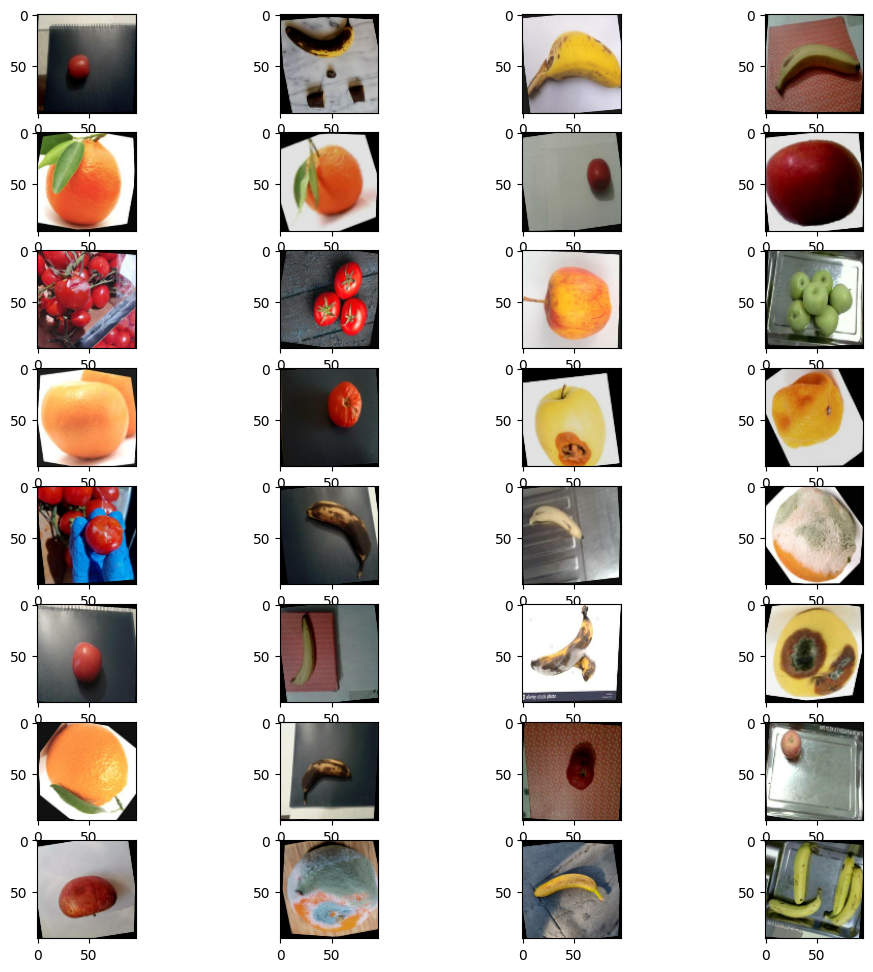

In [5]:
plt.figure(figsize=(12, 12))
for img, label in tqdm(train_ds):
    for i in range(0,32):
        ax = plt.subplot(8, 4, i+1)
        t_img = img[i,:,:,:]
        plt.imshow(t_img)    
    break

Model instances and visualization

In [34]:
# import model definitions
from modules import models,utils
reload(models)
reload(utils)
from modules import models,utils


# Istanciate Model    
model = models.JoJoBizzareModelScalable(num_classes=8, input_size=96, alpha=1.25, beta=4, strides=2, channels=16, gain=2.5)
info,summary = utils.keras_model_memory_usage(model=model,batch_size = 1)
tm = utils.keras_model_mac_ops(model)
print(info,summary,tm)
#model.summary()


╒══════╤════════════════════════════════════╤════════════╤═══════════════════════════╤═════════╤══════════════╤═════════════════════╕
│ N#   │ Layer                              │ Datatype   │   Feature Map Memory (KB) │    MACs │ Parameters   │ Output Shape        │
╞══════╪════════════════════════════════════╪════════════╪═══════════════════════════╪═════════╪══════════════╪═════════════════════╡
│ 1    │ Conv0                              │ float32    │                   184.32  │ 1244160 │ 560          │ (None, 48, 48, 20)  │
├──────┼────────────────────────────────────┼────────────┼───────────────────────────┼─────────┼──────────────┼─────────────────────┤
│ 2    │ CBlock_1_SepConv2D                 │ float32    │                   115.2   │  679680 │ 1230         │ (None, 24, 24, 50)  │
├──────┼────────────────────────────────────┼────────────┼───────────────────────────┼─────────┼──────────────┼─────────────────────┤
│ 3    │ CBlock_1_BatchNorm                 │ float32    │    

Model Training (With QAT) [See Ex4 28/04/2023]

In [ ]:
#tflite
import tensorflow_model_optimization as tfmot

quantize_model = tfmot.quantization.keras.quantize_model

# q_aware stands for for quantization aware.
q_aware_model = quantize_model(model)

# `quantize_model` requires a recompile.
q_aware_model.compile(
        loss='categorical_crossentropy',
        optimizer=optimizers.Adam(learning_rate=0.00002),
        metrics=['accuracy']
    )

q_aware_model.summary()

Model training (Without QAT)

In [38]:
%load_ext tensorboard

#set checkpoint
checkpoint = ModelCheckpoint('savedmodels/'+str(model.name)+'aug_offline.h5', save_best_only=True)
log_dir = "logs/fit/" + str(model.name) +"_run_" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

#train with gpu
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        epochs=1,
        batch_size=32,
        callbacks=[
            checkpoint,
            tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=40, restore_best_weights=True),
            tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', mode='max', patience=8, factor=0.75, min_lr=1e-7),
            tensorboard_callback
            ],
        validation_data=val_ds
    )
s = model.evaluate(val_ds)
info += s
table = [["Number of parameters","Max Act (KB)","N layers","Val loss", "Val accuracy"],info]
with open('table.txt', 'w') as f:
    f.write(tabulate(table, headers='firstrow', tablefmt='fancy_grid'))
#%tensorboard --logdir logs/fit

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
46/46 [==============================] - 0s 5ms/step - loss: 1.1504 - accuracy: 0.5725


Pseudo DSE (Expoliring variations of model)

In [5]:
# Istanciate Model
test_dataset = tf.keras.utils.image_dataset_from_directory(
                              DATADIR_test,
                              labels='inferred',
                              batch_size=20,
                              label_mode='categorical',
                              image_size=(IMAGESIZE, IMAGESIZE))

#extract class names
classes = test_dataset.class_names
#rescale
#test_dataset = test_dataset.map(lambda x, y: (normalization_layer(x), y))
test_dataset = utils.prepare(test_dataset, shuffle=True, augment=False, batch_size=32,img_size=IMAGESIZE)



mod = "alphaDSE"  
for alpha in range(4,25,1):
    val = float("{:.1f}".format(alpha*0.1))
    print(val)
    model = models.JoJoBizzareModelScalable(num_classes=8, input_size=96, alpha=val, beta=4, strides=2, channels=16, gain=2)
    info, summary = utils.keras_model_memory_usage(model=model,batch_size = 1,log = False)
    model_folder = "savedmodels/alphaDSE/"+model.name
    os.makedirs(model_folder)
    checkpoint = ModelCheckpoint(model_folder+'/run.h5', save_best_only=True)
    log_dir = "logs/fit/" + str(model.name) +"_run_" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
    #train with gpu
    with tf.device('/GPU:0'):
        history = model.fit(
            train_ds,
            epochs=200,
            batch_size=32,
            verbose=0,
            callbacks=[
                checkpoint,
                tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=40, restore_best_weights=True),
                tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', mode='max', patience=8, factor=0.6, min_lr=1e-6),
                tensorboard_callback
                ],
            validation_data=val_ds
        )
    s = model.evaluate(val_ds)
    info += s
    table = [["Number of parameters","Max Act (KB)","MACs","N layers","Val loss", "Val accuracy"],info]
    with open(model_folder+'/info.txt', 'w') as f:
        f.write(tabulate(table, headers='firstrow', tablefmt='fancy_grid'))
    with open(model_folder+'/summary.txt', 'w') as f:
        f.write(tabulate(summary, headers='firstrow', tablefmt='fancy_grid'))
    visualkeras.layered_view(model, to_file=model_folder+'/model_img.png',legend=True) # write to disk

    #testing
    model_tmp = tf.keras.models.load_model(model_folder+"/run.h5")
    labels, predictions = utils.predict_from_dataset(test_dataset,model_tmp)
    met = metrics.classification_report(labels, predictions, target_names=classes)
    with open(model_folder+'/classification_report.txt', 'w') as f:
      f.write(met)
    t = confusion_matrix(labels, predictions)
    disp = ConfusionMatrixDisplay(confusion_matrix=t,display_labels=classes)
    s = disp.plot(xticks_rotation='vertical')
    plt.savefig(model_folder+'/confusion_matrix.png',bbox_inches='tight')

0.4


2023-05-06 16:34:28.178083: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [21936]
	 [[{{node Placeholder/_4}}]]
2023-05-06 16:34:28.178439: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [21936]
	 [[{{node Placeholder/_4}}]]
2023-05-06 16:34:35.477665: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8900
2023-05-06 16:34:41.122743: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this messa

46/46 [==============================] - 0s 4ms/step - loss: 0.3712 - accuracy: 0.8707
0.5
46/46 [==============================] - 0s 4ms/step - loss: 0.3703 - accuracy: 0.8789
0.6
46/46 [==============================] - 0s 3ms/step - loss: 0.2969 - accuracy: 0.9083
0.7
46/46 [==============================] - 0s 4ms/step - loss: 0.2521 - accuracy: 0.9138
0.8
46/46 [==============================] - 0s 4ms/step - loss: 0.2916 - accuracy: 0.9090
0.9
46/46 [==============================] - 0s 5ms/step - loss: 0.2710 - accuracy: 0.9097
1.0
46/46 [==============================] - 0s 4ms/step - loss: 0.2598 - accuracy: 0.9193
1.1
46/46 [==============================] - 0s 4ms/step - loss: 0.2606 - accuracy: 0.9145
1.2
46/46 [==============================] - 0s 4ms/step - loss: 0.2569 - accuracy: 0.9227
1.3
46/46 [==============================] - 0s 6ms/step - loss: 0.2721 - accuracy: 0.8995
1.4
46/46 [==============================] - 0s 5ms/step - loss: 0.2747 - accuracy: 0.9207
1.5

KeyboardInterrupt: 

Evaluate performance of FLOAT32 Model

In [26]:
print("Evaluate")
reload(utils)
#load test dataset
test_dataset = tf.keras.utils.image_dataset_from_directory(
                              DATADIR_test,
                              labels='inferred',
                              batch_size=20,
                              label_mode='categorical',
                              image_size=(IMAGESIZE, IMAGESIZE))

#extract class names
classes = test_dataset.class_names
#rescale
#test_dataset = test_dataset.map(lambda x, y: (normalization_layer(x), y))
test_dataset = utils.prepare(test_dataset, shuffle=True, augment=False, batch_size=32,img_size=IMAGESIZE)

labels, predictions = utils.predict_from_dataset(test_dataset,model)


Evaluate
Found 975 files belonging to 8 classes.


  0%|          | 0/49 [00:00<?, ?it/s]2023-05-06 19:53:07.068468: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [975]
	 [[{{node Placeholder/_0}}]]
2023-05-06 19:53:07.069262: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [975]
	 [[{{node Placeholder/_4}}]]
100%|██████████| 49/49 [00:02<00:00, 21.55it/s]


/home/mattiamorabito/Documents/HwAi-linux/savedmodels/alphaDSE/jojo_n8_r96_a1.1_b4_g2_strides2


100%|██████████| 49/49 [00:02<00:00, 18.25it/s]


/home/mattiamorabito/Documents/HwAi-linux/savedmodels/alphaDSE/jojo_n8_r96_a0.3_b4_g2_strides2


100%|██████████| 49/49 [00:02<00:00, 20.02it/s]


/home/mattiamorabito/Documents/HwAi-linux/savedmodels/alphaDSE/jojo_n8_r96_a1.3_b4_g2_strides2


100%|██████████| 49/49 [00:02<00:00, 20.39it/s]


/home/mattiamorabito/Documents/HwAi-linux/savedmodels/alphaDSE/jojo_n8_r96_a0.9_b4_g2_strides2


100%|██████████| 49/49 [00:02<00:00, 19.93it/s]


/home/mattiamorabito/Documents/HwAi-linux/savedmodels/alphaDSE/jojo_n8_r96_a0.5_b4_g2_strides2


100%|██████████| 49/49 [00:02<00:00, 21.03it/s]


/home/mattiamorabito/Documents/HwAi-linux/savedmodels/alphaDSE/jojo_n8_r96_a1.5_b4_g2_strides2


100%|██████████| 49/49 [00:02<00:00, 21.89it/s]


/home/mattiamorabito/Documents/HwAi-linux/savedmodels/alphaDSE/jojo_n8_r96_a0.8_b4_g2_strides2


100%|██████████| 49/49 [00:02<00:00, 18.46it/s]


/home/mattiamorabito/Documents/HwAi-linux/savedmodels/alphaDSE/jojo_n8_r96_a1.2_b4_g2_strides2


100%|██████████| 49/49 [00:02<00:00, 19.81it/s]


/home/mattiamorabito/Documents/HwAi-linux/savedmodels/alphaDSE/jojo_n8_r96_a0.6_b4_g2_strides2


100%|██████████| 49/49 [00:02<00:00, 19.72it/s]


/home/mattiamorabito/Documents/HwAi-linux/savedmodels/alphaDSE/jojo_n8_r96_a1.0_b4_g2_strides2


100%|██████████| 49/49 [00:02<00:00, 16.68it/s]


/home/mattiamorabito/Documents/HwAi-linux/savedmodels/alphaDSE/jojo_n8_r96_a0.2_b4_g2_strides2


100%|██████████| 49/49 [00:03<00:00, 15.31it/s]


/home/mattiamorabito/Documents/HwAi-linux/savedmodels/alphaDSE/jojo_n8_r96_a0.7_b4_g2_strides2


100%|██████████| 49/49 [00:02<00:00, 18.24it/s]


/home/mattiamorabito/Documents/HwAi-linux/savedmodels/alphaDSE/jojo_n8_r96_a0.4_b4_g2_strides2


100%|██████████| 49/49 [00:02<00:00, 20.18it/s]


/home/mattiamorabito/Documents/HwAi-linux/savedmodels/alphaDSE/jojo_n8_r96_a0.1_b4_g2_strides2


100%|██████████| 49/49 [00:02<00:00, 19.25it/s]


/home/mattiamorabito/Documents/HwAi-linux/savedmodels/alphaDSE/jojo_n8_r96_a1.4_b4_g2_strides2


100%|██████████| 49/49 [00:02<00:00, 19.33it/s]


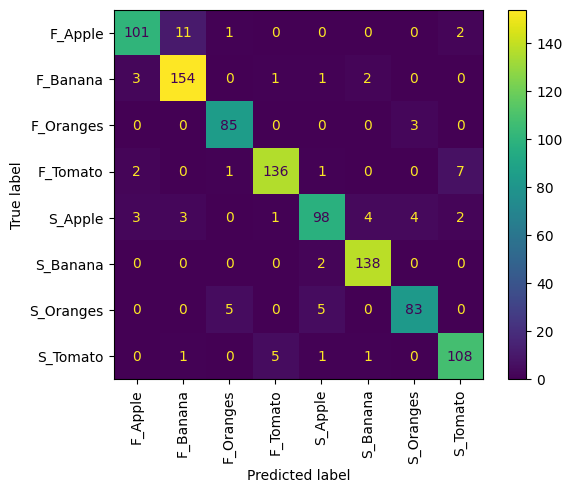

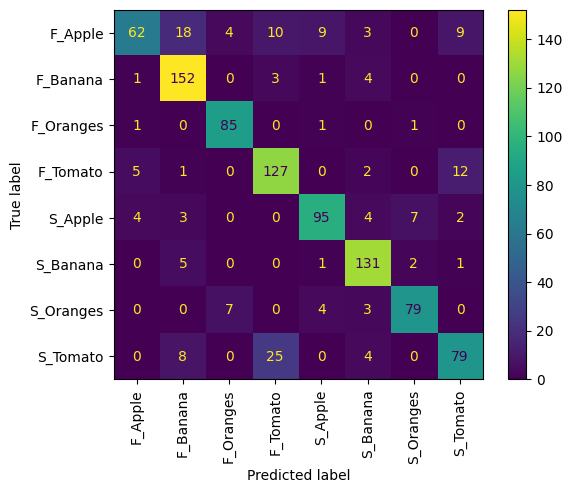

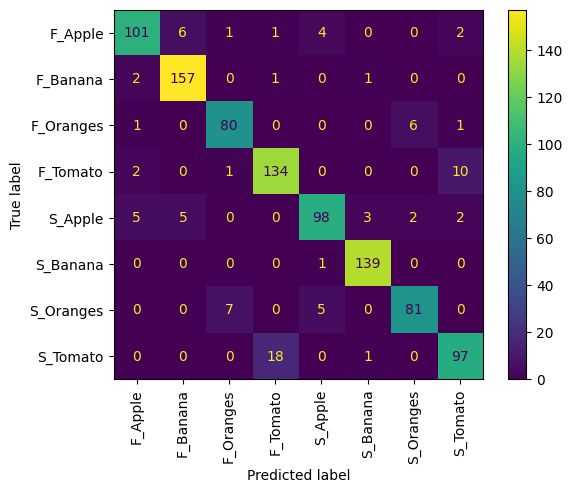

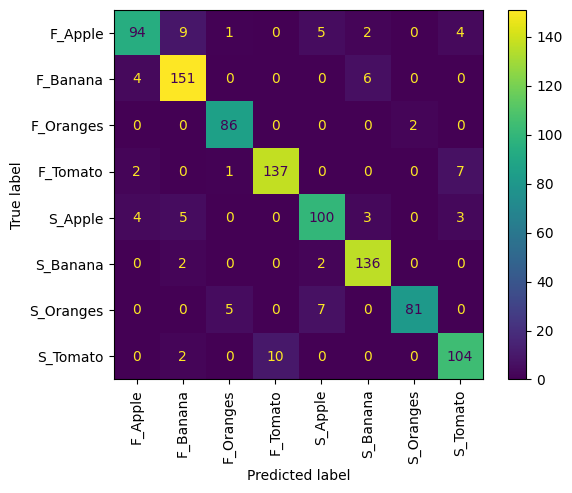

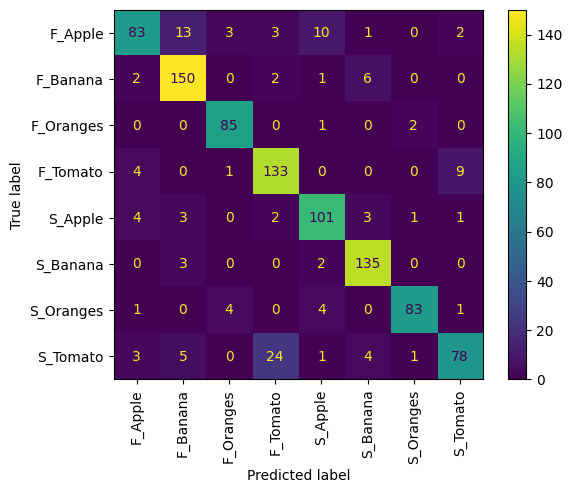

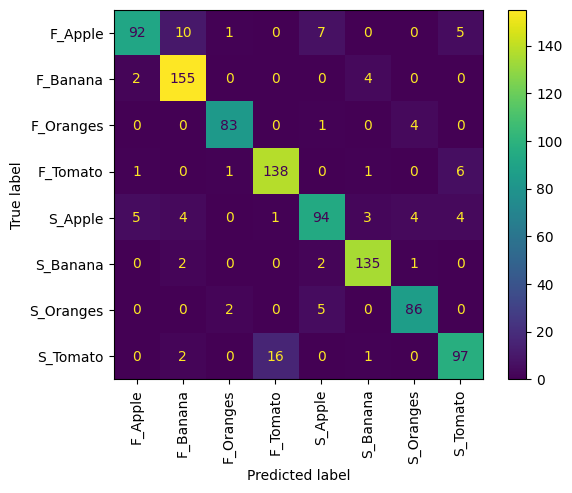

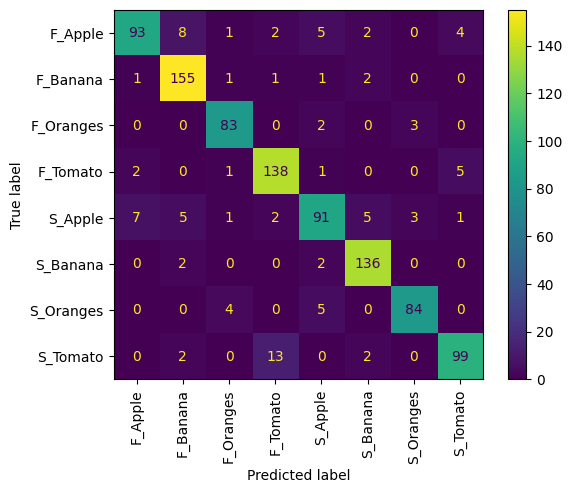

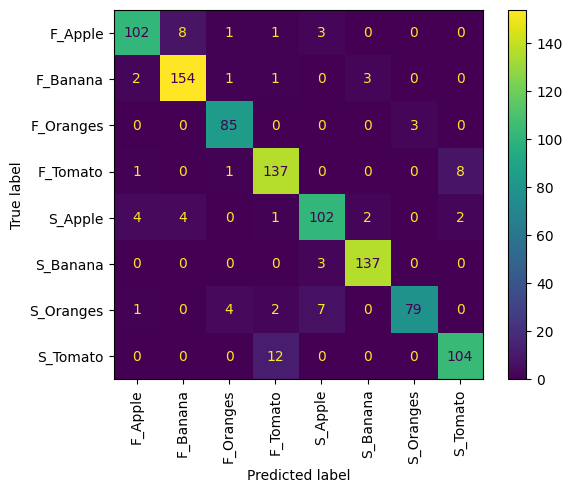

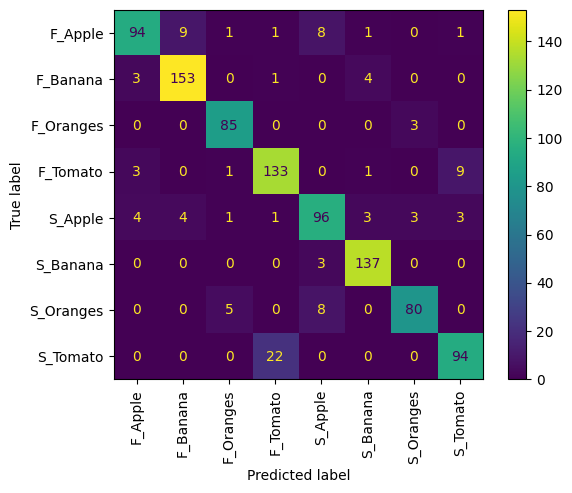

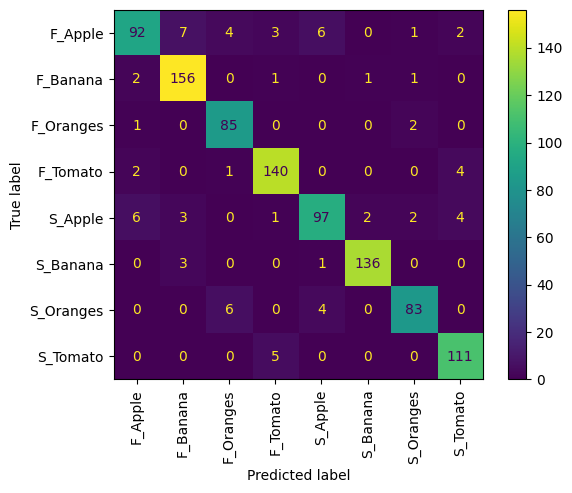

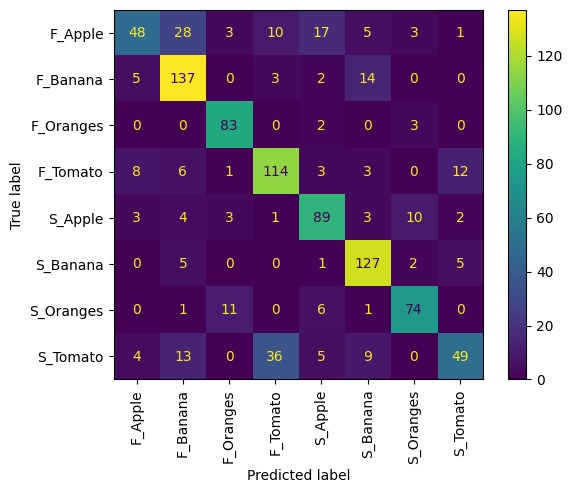

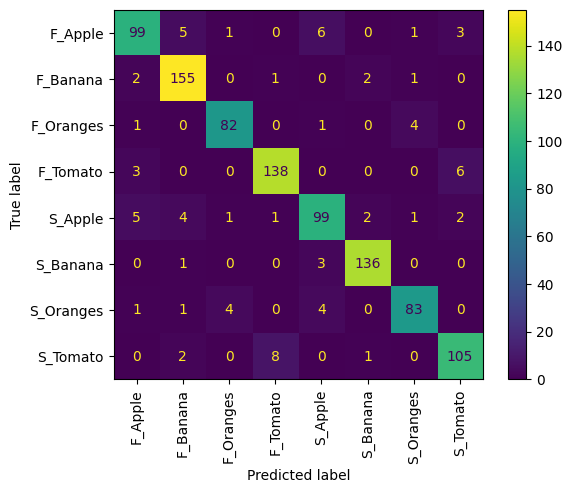

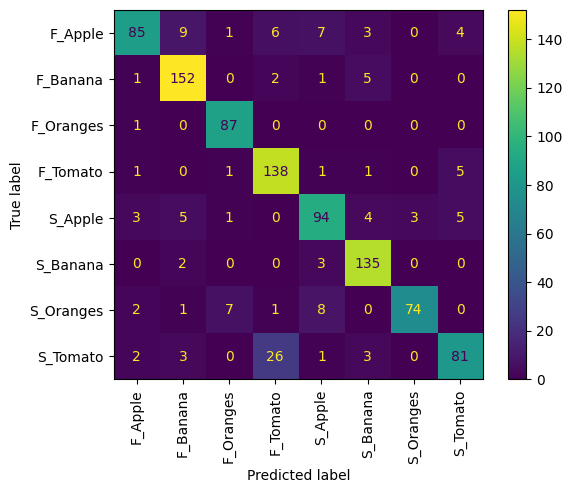

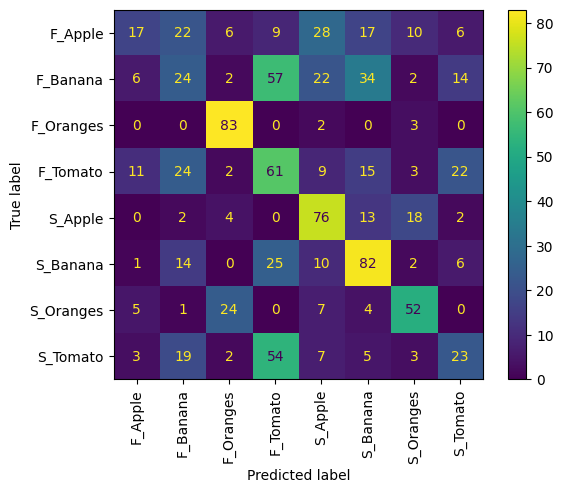

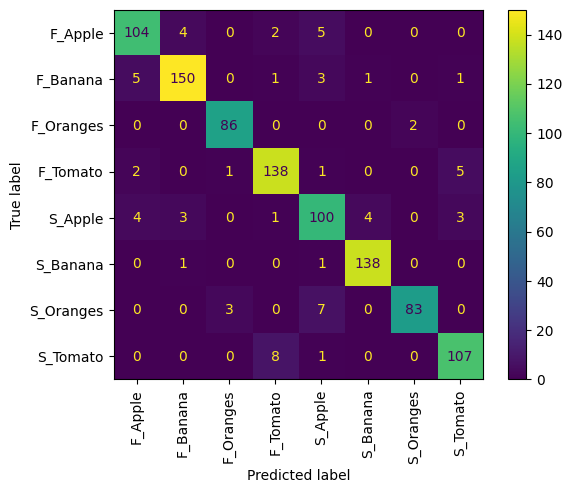

In [44]:
#patch
path = "/home/mattiamorabito/Documents/HwAi-linux/savedmodels/alphaDSE"
for dir in os.listdir(path):
    n_path = path +"/"+dir
    print(n_path)
    model_tmp = tf.keras.models.load_model(n_path+"/run.h5")
    labels, predictions = utils.predict_from_dataset(test_dataset,model_tmp)
    met = metrics.classification_report(labels, predictions, target_names=classes)
    with open(n_path+'/classification_report.txt', 'w') as f:
      f.write(met)
    t = confusion_matrix(labels, predictions)
    disp = ConfusionMatrixDisplay(confusion_matrix=t,display_labels=classes)
    s = disp.plot(xticks_rotation='vertical')
    plt.savefig(n_path+'/confusion_matrix.png',bbox_inches='tight')



0.9107692307692308 0.907150489275232 0.909064764842065
              precision    recall  f1-score   support

     F_Apple       0.94      0.83      0.88       115
    F_Banana       0.92      0.96      0.94       161
   F_Oranges       0.91      0.97      0.94        88
    F_Tomato       0.87      0.92      0.89       147
     S_Apple       0.85      0.92      0.89       115
    S_Banana       0.93      0.98      0.95       140
   S_Oranges       0.96      0.87      0.92        93
    S_Tomato       0.91      0.81      0.86       116

    accuracy                           0.91       975
   macro avg       0.91      0.91      0.91       975
weighted avg       0.91      0.91      0.91       975



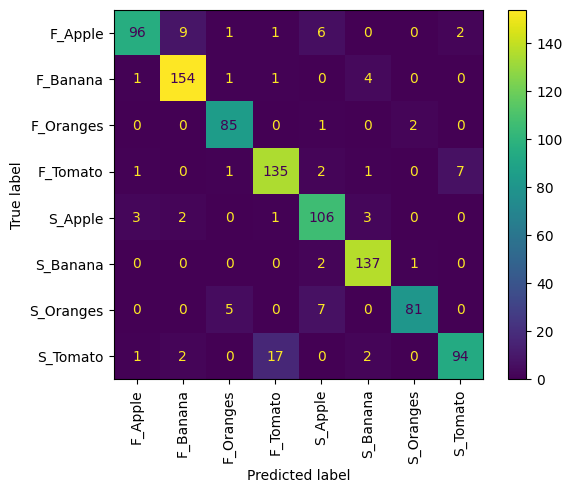

In [30]:
print(metrics.accuracy_score(labels, predictions),
      metrics.balanced_accuracy_score(labels, predictions),
      metrics.f1_score(labels, predictions,average='macro'))

met = metrics.classification_report(labels, predictions, target_names=classes)
print(met)
with open('met.txt', 'w') as f:
      f.write(met)

t = confusion_matrix(labels, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=t,display_labels=classes)
s = disp.plot(xticks_rotation='vertical')
plt.savefig("test.png",bbox_inches='tight')
plt.show()

Save model and convert to TFlite

In [21]:
MODEL_NAME = "/home/mattiamorabito/Documents/HwAi-linux/savedmodels/"+str(model.name)
tf.saved_model.save(model, MODEL_NAME)

converter = tf.lite.TFLiteConverter.from_saved_model(MODEL_NAME)
converter.optimizations = [tf.lite.Optimize.DEFAULT]


def representative_data_gen():                          # Uncomment the following 5 lines for Model 3
    for input_value, _ in test_dataset.take(20):
        yield [input_value]
converter.representative_dataset = representative_data_gen
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
#converter.inference_input_type = tf.uint8
#converter.inference_output_type = tf.uint8

tflite_model = converter.convert()
tflite_models_dir = "/home/mattiamorabito/Documents/HwAi-linux/tflite/"

tflite_model_file = pathlib.Path(tflite_models_dir+model.name+'.tflite')
tflite_model_file.write_bytes(tflite_model)

2023-05-05 17:41:25.977075: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
2023-05-05 17:41:25.977103: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
2023-05-05 17:41:25.977299: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /home/mattiamorabito/Documents/HwAi-linux/savedmodels/jojo_n8_r96_a1.0_b4_g2.5_strides2
2023-05-05 17:41:25.980249: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2023-05-05 17:41:25.980279: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /home/mattiamorabito/Documents/HwAi-linux/savedmodels/jojo_n8_r96_a1.0_b4_g2.5_strides2
2023-05-05 17:41:25.992154: I tensorflow/cc/saved_model/loader.cc:231] Restoring SavedModel bundle.
2023-05-05 17:41:26.093341: I tensorflow/cc/saved_model/loader.cc:215] Running initialization op on SavedModel bundle at path: /home/mattiamor

66008

Test quantized model

In [22]:
#tflite_models_dir = pathlib.Path("/home/mattiamorabito/Documents/HwAi-linux/tflite/")
#tflite_model_file = tflite_models_dir/'jojo_noINT.tflite'
interpreter = tf.lite.Interpreter(model_path=str(tflite_model_file))
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

input_index = interpreter.get_input_details()[0]["index"]
output_index = interpreter.get_output_details()[0]["index"]

predictions = []

test_ds = tf.keras.utils.image_dataset_from_directory(DATADIR_test,labels='inferred',batch_size=1,label_mode='categorical')
#test_ds = test_ds.map(lambda x, y: (normalization_layer(x), y))
test_ds = utils.prepare(test_ds, shuffle=True, augment=False, batch_size=32,img_size=IMAGESIZE)


test_labels, test_imgs = [], []
for img, label in tqdm(test_ds):
    interpreter.set_tensor(input_index, img)
    interpreter.invoke()
    predictions.append(interpreter.get_tensor(output_index))
    test_labels.append(label.numpy()[0])
    test_imgs.append(img)


score = 0
for item in range(0,len(predictions)):
  prediction=np.argmax(predictions[item])
  label = np.argmax(test_labels[item])
  if prediction==label:
    score=score+1
print("| Out of "+str(len(predictions))+" predictions I got " + str(score) + " correct | Accuracy: "+ str(score/len(predictions)*100) + "% |")

Found 975 files belonging to 8 classes.


  0%|          | 0/975 [00:00<?, ?it/s]2023-05-05 17:41:31.942450: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [975]
	 [[{{node Placeholder/_0}}]]
2023-05-05 17:41:31.943170: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [975]
	 [[{{node Placeholder/_4}}]]
100%|██████████| 975/975 [00:00<00:00, 1607.47it/s]

| Out of 975 predictions I got 903 correct | Accuracy: 92.61538461538461% |


See model structure and history

Model: "jojo_n8_r96_a1.0_b4_g2.5_strides2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Conv0 (Conv2D)              (None, 48, 48, 16)        448       
                                                                 
 CBlock_1_SepConv2D (Separab  (None, 24, 24, 40)       824       
 leConv2D)                                                       
                                                                 
 CBlock_1_BatchNorm (BatchNo  (None, 24, 24, 40)       160       
 rmalization)                                                    
                                                                 
 CBlock_1_ReLu (ReLU)        (None, 24, 24, 40)        0         
                                                                 
 CBlock_2_SepConv2D (Separab  (None, 12, 12, 80)       3640      
 leConv2D)                                                       
                                 

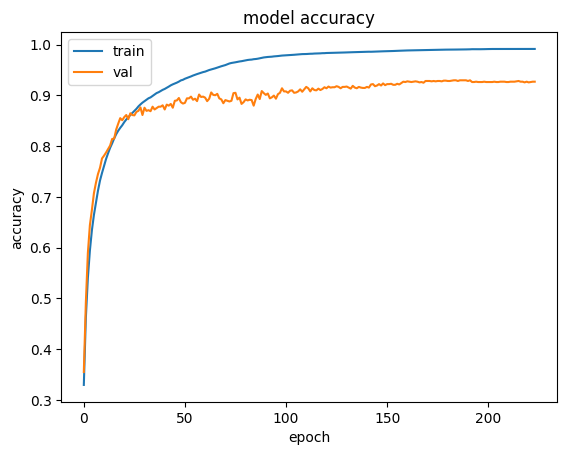

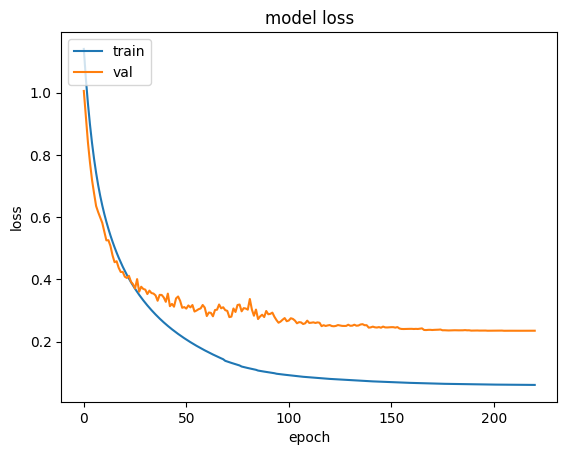

In [23]:
# see model structure
visualkeras.layered_view(model,legend=True).show() # display using your system viewer
model.summary()

# model training history
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(history.history['loss'][3:])
plt.plot(history.history['val_loss'][3:])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Weight distrubution

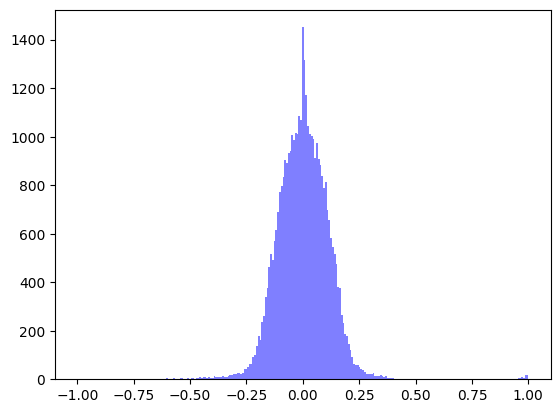

In [24]:
all_wi = []
wi = model.weights
for elem in wi:
  var = list(elem.read_value().numpy().flatten())
  all_wi= all_wi +var
s = np.array(all_wi)
sbins = np.linspace(-1,1,256)
plt.hist(s, bins=sbins, facecolor='blue', alpha=0.5)
plt.show()